<a href="https://colab.research.google.com/github/danchaud-vincent/tensorflow-deep-learning/blob/main/exexcises-solutions/05_Transfer_Learning_in_TensorFlow_Part_2_Fine_tuning_Exercise_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 05 - Transfer Learning in TensorFlow Part 2: Fine-tuning Exercices


**Questions:**


1. Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using `tf.keras.applications.EfficientNetB0` as the base model. Use the `ModelCheckpoint` callback to save the weights to file.
2. Fine-tune the last 20 layers of the base model you trained in 2 for another 10 epochs. How did it go?
3. Fine-tune the last 30 layers of the base model you trained in 2 for another 10 epochs. How dit it go ?
4. Write a function to visualize an image from any dataset (train or test file) and any class (e.g. "steak", "pizza",... etc), visualize it and make a prediction on it using a trained model.

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

## Download and Explore the data

### Download the data

In [1]:
# getting the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2022-11-06 10:17:55--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.148.128, 209.85.200.128, 142.250.152.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.148.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   113MB/s    in 1.4s    

2022-11-06 10:17:56 (113 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# unzip the folder 
import zipfile

path_file = "10_food_classes_10_percent.zip"

with zipfile.ZipFile(path_file,"r")  as zip_ref:
  zip_ref.extractall()

### Explore the folder containing the data

In [13]:
# Walk through the folder containing the data
import os
data_dir = "10_food_classes_10_percent"

for dirpath, foldername, filename in os.walk(data_dir):
  print(f"There are {len(filename)} files in : {dirpath}")

There are 0 files in : 10_food_classes_10_percent
There are 0 files in : 10_food_classes_10_percent/train
There are 75 files in : 10_food_classes_10_percent/train/grilled_salmon
There are 75 files in : 10_food_classes_10_percent/train/fried_rice
There are 75 files in : 10_food_classes_10_percent/train/ramen
There are 75 files in : 10_food_classes_10_percent/train/hamburger
There are 75 files in : 10_food_classes_10_percent/train/sushi
There are 75 files in : 10_food_classes_10_percent/train/pizza
There are 75 files in : 10_food_classes_10_percent/train/ice_cream
There are 75 files in : 10_food_classes_10_percent/train/chicken_curry
There are 75 files in : 10_food_classes_10_percent/train/chicken_wings
There are 75 files in : 10_food_classes_10_percent/train/steak
There are 0 files in : 10_food_classes_10_percent/test
There are 250 files in : 10_food_classes_10_percent/test/grilled_salmon
There are 250 files in : 10_food_classes_10_percent/test/fried_rice
There are 250 files in : 10_foo

In [24]:
# get the class names 
import pathlib

train_dir = "10_food_classes_10_percent/train"
data_dir = pathlib.Path(train_dir)
class_names = sorted([item.name for item in data_dir.glob("*")])

class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

### Visualize the data

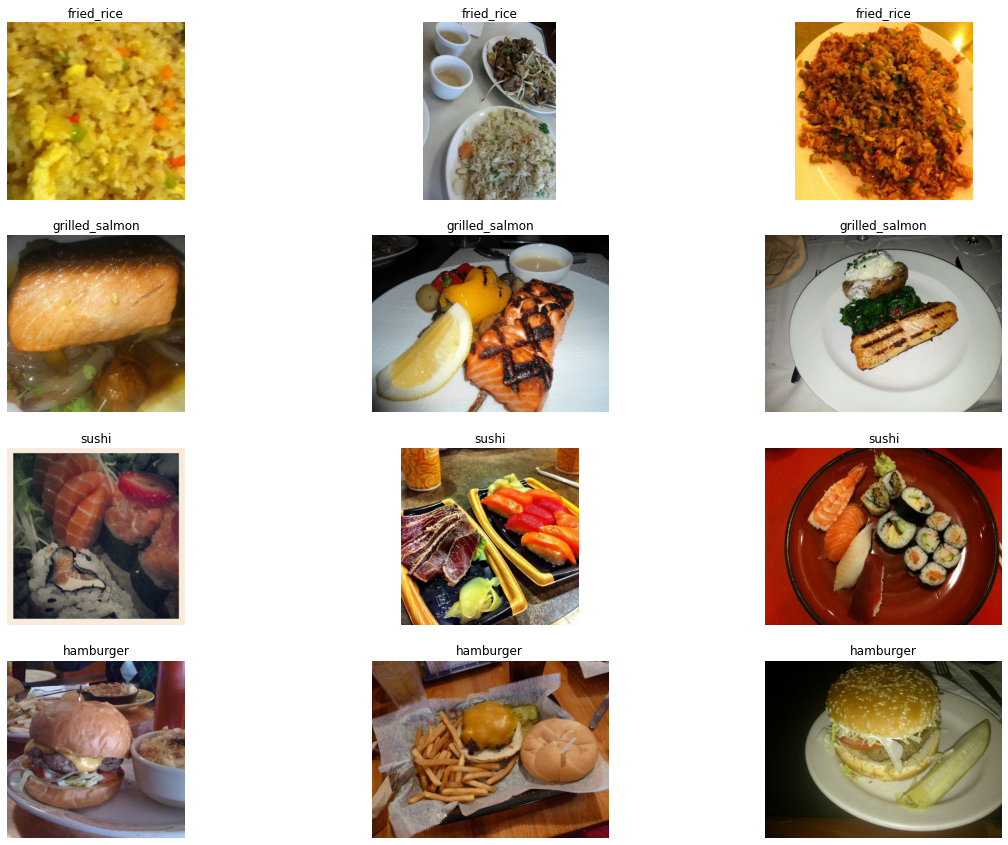

In [32]:
# get random images and visualize it
import random
import matplotlib.image as mpimg

# set number of classes and images to visualiz
nb_image_per_class = 3
nb_classes = 4

# set the train directory
train_dir = "10_food_classes_10_percent/train" 

# get random classes from the list of classes
random_classes = random.sample(class_names, nb_classes)

# create a figure
plt.figure(figsize=(20,15))
index = 1

for i, item_class in enumerate(random_classes):

  # set the class directory
  class_dir = train_dir + "/" + item_class

  # list of the images in the class directory
  list_images = os.listdir(class_dir)

  # get random images
  random_images = random.sample(list_images,nb_image_per_class)

  for j, image_item in enumerate(random_images):

    # set the image directory
    image_dir = class_dir + "/" + image_item

    # read the image
    img = mpimg.imread(image_dir)

    # visualize the image
    plt.subplot(nb_classes,nb_image_per_class, index)
    plt.imshow(img)
    plt.axis("off")
    plt.title(item_class)

    index += 1

In [38]:
# visualize the array of an image
class_name = "hamburger"
list_images = os.listdir(f"{train_dir}/{class_name}")
random_image = random.sample(list_images, 1)[0]

img = mpimg.imread(f"{train_dir}/{class_name}/{random_image}")

print(f"Shape of the img: {img.shape}")
print(f"Max value in the array: {img.max()}")
print(f"Min value in the array:{img.min()}")
print(img)

Shape of the img: (384, 512, 3)
Max value in the array: 255
Min value in the array:0
[[[  1   2   4]
  [  1   2   4]
  [  2   3   5]
  ...
  [  3   8   2]
  [  3   8   4]
  [  4  10   6]]

 [[  1   3   2]
  [  1   3   2]
  [  2   4   3]
  ...
  [  4   9   3]
  [  4   9   5]
  [  5  11   7]]

 [[  1   3   2]
  [  1   3   2]
  [  1   3   2]
  ...
  [  5  10   4]
  [  5  10   6]
  [  6  12   8]]

 ...

 [[115  84   4]
  [115  83   6]
  [112  80   3]
  ...
  [  2   2   4]
  [  3   2   7]
  [  6   3  10]]

 [[113  82   2]
  [113  82   2]
  [110  79   0]
  ...
  [  2   2   4]
  [  3   2   7]
  [  6   3  10]]

 [[110  79   0]
  [110  79   0]
  [108  77   0]
  ...
  [  2   2   4]
  [  3   2   7]
  [  6   3  10]]]


## Build a transfer learning model using the Keras Functional API

### Preprocess the data

In [39]:
# set the train and test dir
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [41]:
# Create data inputs
IMG_SIZE = (224,224)
BATCH_SIZE = 32

print("--- train dataset ---")
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="categorical",
                                                                 batch_size=BATCH_SIZE)

print("--- test dataset ---")
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

--- train dataset ---
Found 750 files belonging to 10 classes.
--- test dataset ---
Found 2500 files belonging to 10 classes.


In [42]:
# Check the train_data datatype
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [43]:
# class names of the train_data
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [45]:
# See an example of a batch of data
train_data.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [48]:
for images,labels in train_data.take(1):
  print(images)
  print(labels)

tf.Tensor(
[[[[111.571434   104.571434    26.571428  ]
   [112.59694    105.59694     25.59694   ]
   [113.         105.          24.        ]
   ...
   [ 38.3623      22.076588    15.076589  ]
   [ 38.21427     21.928558    14.928558  ]
   [ 38.158184    21.87247     14.872472  ]]

  [[105.52551     98.38266     20.45408   ]
   [105.852036    96.852036    17.994898  ]
   [104.984695    96.18368     16.785715  ]
   ...
   [ 34.67349     19.673489    12.673488  ]
   [ 35.92857     20.928572    13.928572  ]
   [ 33.474453    18.474453    11.474453  ]]

  [[104.28061     95.28061     18.280613  ]
   [102.27041     93.27041     16.270409  ]
   [101.04592     92.04592     14.617347  ]
   ...
   [ 32.42855     18.999977    12.785692  ]
   [ 34.158154    20.729582    14.515296  ]
   [ 30.219292    16.79072     10.576433  ]]

  ...

  [[ 10.137761    10.137761     8.137761  ]
   [ 12.214294    11.214294     7.2142944 ]
   [ 12.642858    11.           7.214286  ]
   ...
   [171.83162    148.831

### Build a Tensorboard callback and a ModelCheckpoint callback

In [49]:
# Tensorboard callback
import datetime

def create_tensorboard_callback(dirname, experiment_name):
  """
  Create a tensorboard callback

  Arguments:
  - dirname (str): target directory to stores TensorBoard log files
  - experiment_name (str): name of the experiment directory

  Returns:
  - tensorboar_callback
  """
  # get the time
  time_now = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

  # path of the directory to save the log files
  log_dir = f"{dirname}/{experiment_name}/{time_now}"

  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

  return tensorboard_callback

In [50]:
# Create a ModelCheckpoint

# checkpoint path
checkpoint_path = "model_checkpoints/checkpoint.ckpt"

# Create a ModelCheckpoint to save best weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         save_freq="epoch",
                                                         verbose=1)